In [188]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [189]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [190]:
movie_reviews.shape

(50000, 2)

In [191]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [192]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

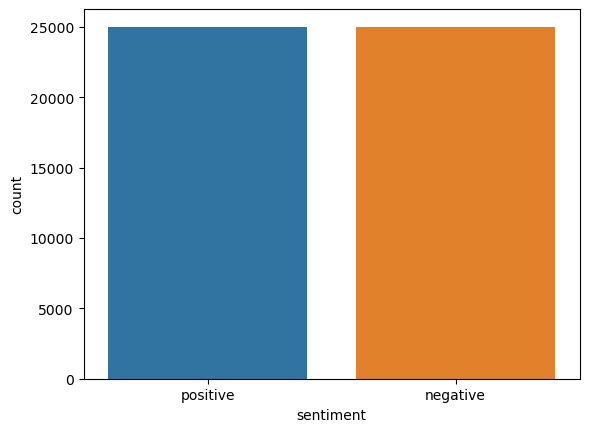

In [193]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

# Data Preprocessing

In [194]:
movie_reviews["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [195]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [196]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [197]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [198]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [199]:
# Sample cleaned up movie review 

X[0]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

In [200]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

# VADER

In [214]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\baiba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [215]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [234]:
res = {}
for i, row in tqdm(movie_reviews.iterrows(), total=len(movie_reviews)):
    text = row['review']
    myid = i
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [235]:
vaders = pd.DataFrame(res).T

In [236]:
vaders

,neg,neu,pos,compound
0,0.203,0.748,0.048,-0.9951
1,0.053,0.776,0.172,0.9641
2,0.094,0.714,0.192,0.9605
3,0.138,0.797,0.065,-0.9213
4,0.052,0.801,0.147,0.9744
...,...,...,...,...
49995,0.047,0.753,0.199,0.9890
49996,0.166,0.720,0.114,-0.6693
49997,0.208,0.683,0.108,-0.9851
49998,0.105,0.813,0.082,-0.7648


In [237]:
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
movie_reviews = movie_reviews.reset_index().rename(columns={'index': 'Id'})

In [238]:
vaders

,Id,neg,neu,pos,compound
0,0,0.203,0.748,0.048,-0.9951
1,1,0.053,0.776,0.172,0.9641
2,2,0.094,0.714,0.192,0.9605
3,3,0.138,0.797,0.065,-0.9213
4,4,0.052,0.801,0.147,0.9744
...,...,...,...,...,...
49995,49995,0.047,0.753,0.199,0.9890
49996,49996,0.166,0.720,0.114,-0.6693
49997,49997,0.208,0.683,0.108,-0.9851
49998,49998,0.105,0.813,0.082,-0.7648


In [241]:
#movie_reviews.drop(movie_reviews.iloc[:, 1:3], inplace=True, axis=1)

In [244]:
movie_reviews = movie_reviews.reset_index().rename(columns={'index': 'Id'})

In [247]:
vaders = vaders.merge(movie_reviews, how='left')
vaders

,Id,neg,neu,pos,compound,review,sentiment
0,0,0.203,0.748,0.048,-0.9951,One of the other reviewers has mentioned that ...,positive
1,1,0.053,0.776,0.172,0.9641,A wonderful little production. <br /><br />The...,positive
2,2,0.094,0.714,0.192,0.9605,I thought this was a wonderful way to spend ti...,positive
3,3,0.138,0.797,0.065,-0.9213,Basically there's a family where a little boy ...,negative
4,4,0.052,0.801,0.147,0.9744,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...,...,...,...,...,...
49995,49995,0.047,0.753,0.199,0.9890,I thought this movie did a down right good job...,positive
49996,49996,0.166,0.720,0.114,-0.6693,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,49997,0.208,0.683,0.108,-0.9851,I am a Catholic taught in parochial elementary...,negative
49998,49998,0.105,0.813,0.082,-0.7648,I'm going to have to disagree with the previou...,negative


In [254]:
vaders['predicted sentiment'] = vaders['compound'].apply(lambda x: 'positive' if x > 0 else 'negative')


In [255]:
vaders

,Id,neg,neu,pos,compound,review,sentiment,predicted sentiment
0,0,0.203,0.748,0.048,-0.9951,One of the other reviewers has mentioned that ...,positive,negative
1,1,0.053,0.776,0.172,0.9641,A wonderful little production. <br /><br />The...,positive,positive
2,2,0.094,0.714,0.192,0.9605,I thought this was a wonderful way to spend ti...,positive,positive
3,3,0.138,0.797,0.065,-0.9213,Basically there's a family where a little boy ...,negative,negative
4,4,0.052,0.801,0.147,0.9744,"Petter Mattei's ""Love in the Time of Money"" is...",positive,positive
...,...,...,...,...,...,...,...,...
49995,49995,0.047,0.753,0.199,0.9890,I thought this movie did a down right good job...,positive,positive
49996,49996,0.166,0.720,0.114,-0.6693,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,negative
49997,49997,0.208,0.683,0.108,-0.9851,I am a Catholic taught in parochial elementary...,negative,negative
49998,49998,0.105,0.813,0.082,-0.7648,I'm going to have to disagree with the previou...,negative,negative


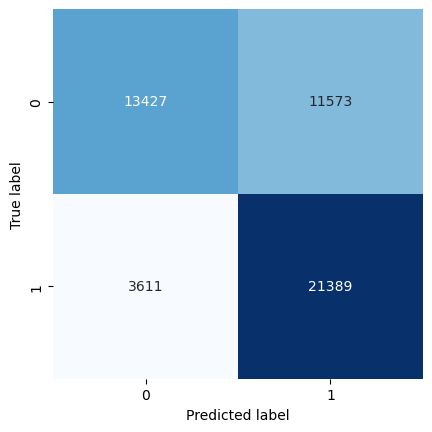

In [256]:
from sklearn.metrics import confusion_matrix

y_predicted = vaders['predicted sentiment']
mat = confusion_matrix(vaders['sentiment'], y_predicted)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [262]:
true = sum(np.diag(mat))
accuracy = round((true/movie_reviews.shape[0])*100,2)
accuracy

69.63

# Preparing embedding layer

Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [202]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer, processes the text and builds the vocabulary based on the words present in the training data. It assigns unique integer indices to each word in the vocabulary.
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

# After this step, X_train becomes a list of sequences, where each sequence is a list of integers representing the words in the original sentences.

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [206]:
len(X_train)

40000

In [207]:
# This dictionary is built during the fitting step of the Tokenizer object using the fit_on_texts method.
# Each unique word in the vocabulary is assigned a unique integer index.

word_tokenizer.word_index

{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'good': 5,
 'time': 6,
 'even': 7,
 'would': 8,
 'story': 9,
 'really': 10,
 'see': 11,
 'well': 12,
 'much': 13,
 'bad': 14,
 'get': 15,
 'people': 16,
 'great': 17,
 'also': 18,
 'first': 19,
 'made': 20,
 'make': 21,
 'could': 22,
 'way': 23,
 'movies': 24,
 'think': 25,
 'characters': 26,
 'watch': 27,
 'character': 28,
 'films': 29,
 'seen': 30,
 'two': 31,
 'many': 32,
 'plot': 33,
 'never': 34,
 'love': 35,
 'life': 36,
 'acting': 37,
 'best': 38,
 'know': 39,
 'show': 40,
 'little': 41,
 'ever': 42,
 'man': 43,
 'better': 44,
 'end': 45,
 'scene': 46,
 'still': 47,
 'say': 48,
 'scenes': 49,
 'something': 50,
 'go': 51,
 'back': 52,
 'real': 53,
 'watching': 54,
 'thing': 55,
 'actors': 56,
 'though': 57,
 'years': 58,
 'director': 59,
 'funny': 60,
 'old': 61,
 'another': 62,
 'actually': 63,
 'work': 64,
 'makes': 65,
 'nothing': 66,
 'look': 67,
 'going': 68,
 'find': 69,
 'lot': 70,
 'new': 71,
 'every': 72,
 'part': 73,
 'wo

In [208]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [209]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [210]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [211]:
len(embeddings_dictionary)

400000

In [212]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [213]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38251001,  0.14821   ,  0.60601002, ...,  0.058921  ,
         0.091112  ,  0.47283   ],
       [ 0.19915999, -0.049702  ,  0.24579   , ..., -0.068109  ,
         0.017651  ,  0.06455   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

# Model Training

## Simple Neural Network

In [67]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [68]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [69]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 6ms/step - loss: 0.5614 - acc: 0.7106 - val_loss: 0.5146 - val_acc: 0.7495
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4497 - acc: 0.7938 - val_loss: 0.4928 - val_acc: 0.7640
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4153 - acc: 0.8152 - val_loss: 0.5176 - val_acc: 0.7575
Epoch 4/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3923 - acc: 0.8275 - val_loss: 0.5059 - val_acc: 0.7616
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3756 - acc: 0.8355 - val_loss: 0.5221 - val_acc: 0.7589
Epoch 6/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3654 - acc: 0.8422 - val_loss: 0.5296 - val_acc: 0.7555


In [70]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5585 - acc: 0.7527


In [73]:
# Model Performance

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5585147142410278
Test Accuracy: 0.7526999711990356


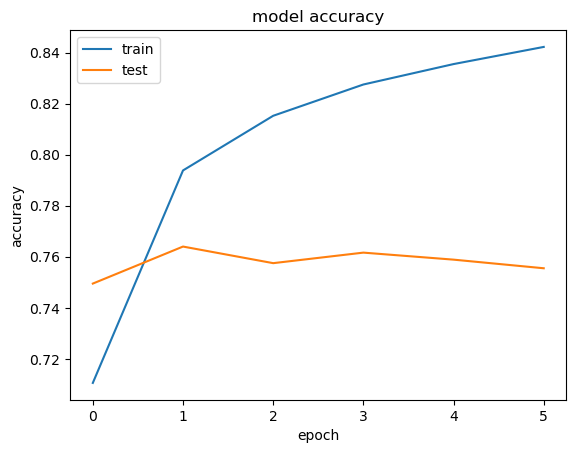

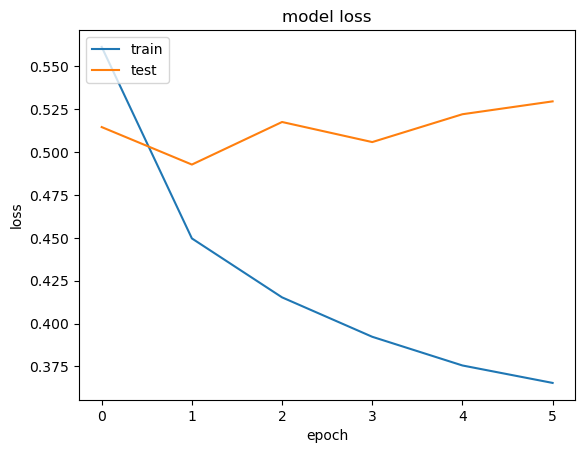

In [74]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [75]:
from keras.layers import Conv1D

In [76]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [77]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [78]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 16s 62ms/step - loss: 0.4618 - acc: 0.7807 - val_loss: 0.3895 - val_acc: 0.8216
Epoch 2/6
250/250 [==============================] - 22s 87ms/step - loss: 0.3361 - acc: 0.8575 - val_loss: 0.3428 - val_acc: 0.8520
Epoch 3/6
250/250 [==============================] - 22s 87ms/step - loss: 0.2799 - acc: 0.8886 - val_loss: 0.3343 - val_acc: 0.8558
Epoch 4/6
250/250 [==============================] - 18s 71ms/step - loss: 0.2380 - acc: 0.9097 - val_loss: 0.3498 - val_acc: 0.8443
Epoch 5/6
250/250 [==============================] - 17s 70ms/step - loss: 0.1986 - acc: 0.9323 - val_loss: 0.3350 - val_acc: 0.8531
Epoch 6/6
250/250 [==============================] - 17s 69ms/step - loss: 0.1629 - acc: 0.9504 - val_loss: 0.3323 - val_acc: 0.8559


In [79]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 6s 20ms/step - loss: 0.3307 - acc: 0.8570


In [80]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33070018887519836
Test Accuracy: 0.8569999933242798


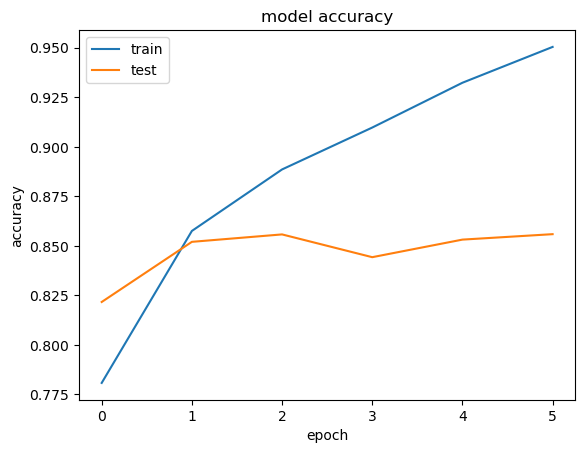

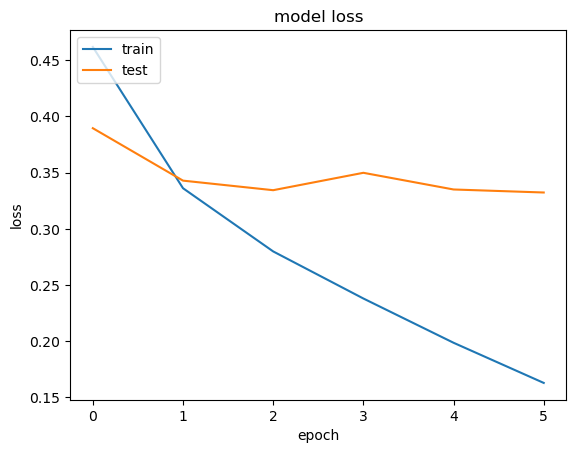

In [81]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [143]:
from keras.layers import LSTM

In [144]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(8, activation='relu'))

lstm_model.add(Dense(1, activation='sigmoid'))

In [145]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          9239400   
                                                                 
 lstm_14 (LSTM)              (None, 128)               117248    
                                                                 
 dense_26 (Dense)            (None, 8)                 1032      
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9357689 (35.70 MB)
Trainable params: 118289 (462.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [146]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 67s 259ms/step - loss: 0.5554 - acc: 0.7210 - val_loss: 0.5227 - val_acc: 0.7801
Epoch 2/6
250/250 [==============================] - 68s 272ms/step - loss: 0.4363 - acc: 0.8031 - val_loss: 0.3981 - val_acc: 0.8256
Epoch 3/6
250/250 [==============================] - 72s 287ms/step - loss: 0.3835 - acc: 0.8322 - val_loss: 0.3552 - val_acc: 0.8454
Epoch 4/6
250/250 [==============================] - 73s 294ms/step - loss: 0.3453 - acc: 0.8536 - val_loss: 0.3402 - val_acc: 0.8534
Epoch 5/6
250/250 [==============================] - 71s 286ms/step - loss: 0.3257 - acc: 0.8637 - val_loss: 0.3262 - val_acc: 0.8604
Epoch 6/6
250/250 [==============================] - 71s 285ms/step - loss: 0.3096 - acc: 0.8714 - val_loss: 0.3163 - val_acc: 0.8652


In [147]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 15s 48ms/step - loss: 0.3184 - acc: 0.8612


In [148]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3183802366256714
Test Accuracy: 0.8611999750137329


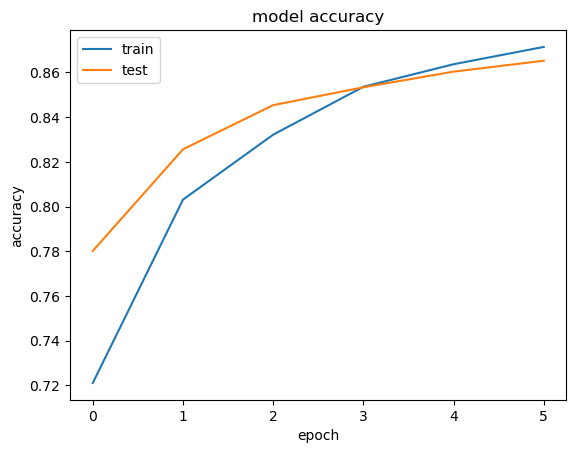

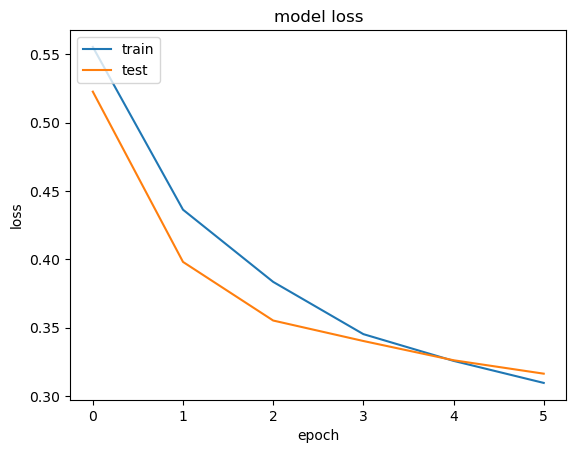

In [149]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [150]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

C:\Users\baiba\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predictions on Live IMDb data

In [158]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [159]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [160]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [161]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [162]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 54ms/step


array([[0.9568987 ],
       [0.99105996],
       [0.1523546 ],
       [0.7272547 ],
       [0.9750801 ],
       [0.02261175]], dtype=float32)

In [163]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.6
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.5
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,7.3
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
